In [96]:
import pandas as pd
import zipfile  
import json
import seaborn as sns 

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Parsing

In [5]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [7]:
#train
jsonsList_train =  []
with zipfile.ZipFile("data/raw/source-4-ds-train.json.zip", "r") as z:
    for filename in z.namelist():  
        with z.open(filename) as f:  
            for line in f:
                jsonsList_train.append(flatten_json(json.loads(line)))
dataset_train = pd.DataFrame(data=jsonsList_train)
dataset_train.to_csv('data/processed/train.csv.gzip', sep =';', index=False,  compression="gzip")

In [8]:
#test
jsonsList_test =  []
with zipfile.ZipFile("data/raw/source-4-ds-test.json.zip", "r") as z:
    for filename in z.namelist():  
        with z.open(filename) as f:
            for line in f:
                jsonsList_test.append(flatten_json(json.loads(line)))
dataset_test = pd.DataFrame(data=jsonsList_test)
dataset_test.to_csv('data/processed/test.csv.gzip', sep =';', index=False, compression='gzip')

### Exploring

In [148]:
dataset = pd.read_csv('data/processed/train.csv.gzip',compression='gzip', sep =';')

/home/willy/git/imoveis/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,8,10,13,19,22,26,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
dataset.sample(1)

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation_precision,address_geoLocation_location_lon,address_geoLocation_location_lat,address_street,address_locationId,address_district,address_unitNumber,address_state,address_neighborhood,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos_price,pricingInfos_businessType,pricingInfos_period,pricingInfos_yearlyIptu,pricingInfos_rentalTotalPrice,pricingInfos_monthlyCondoFee
36547,116.000,"Lindo apartamento, com 116m², com 2 dormitório...","Apartamento com 2 dormitórios à venda, 116 m² ...",2019-02-14T04:50:42.203Z,316d75f06f,APARTMENT,ACTIVE,cbf585a1df,1.000,2019-02-24T23:33:49.538Z,False,['http://images.ingaiasites.com.br/3nHL8gqShTM...,NaN,1405001.000,São Paulo,NaN,NaN,GEOMETRIC_CENTER,-46.657,-23.567,Rua Pamplona,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim Pa...,NaN,NaN,São Paulo,Jardim Paulista,0.000,STANDARD,1.000,nan,2.000,558600,SALE,NaN,213.000,nan,1330.000


In [150]:
y = dataset.pricingInfos_price

TypeError: could not convert string to float: '<br />-3 banheiros, '

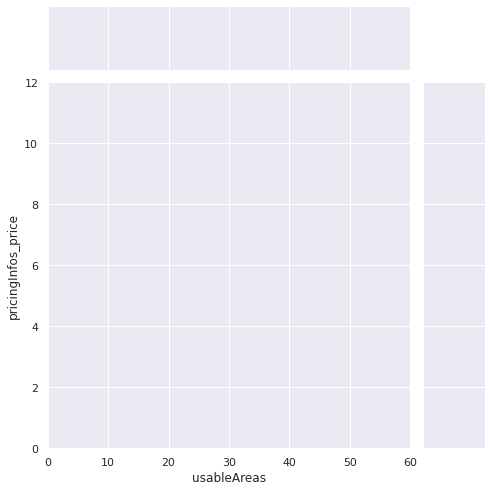

In [153]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="usableAreas", y="pricingInfos_price", data=dataset[['pricingInfos_price','usableAreas' ]],
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

In [152]:
dataset.drop(index = [31163,102472,31151,31152], inplace =True)

In [145]:
dataset.usableAreas.str.contains('[a-zA-Z]')

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
133973    NaN
133974    NaN
133975    NaN
133976    NaN
133977    NaN
Name: usableAreas, Length: 133974, dtype: object

In [156]:
dataset.usableAreas.apply(lambda x: True if x.str.contains('[a-zA-Z]') else False)

SyntaxError: invalid syntax (<ipython-input-156-500216578fb9>, line 1)

In [139]:
dataset[dataset['usableAreas'] == '<br />-3 dormitórios com armários embutidos de ótima qualidade,sendo 1 suíte, ']


,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation_precision,address_geoLocation_location_lon,address_geoLocation_location_lat,address_street,address_locationId,address_district,address_unitNumber,address_state,address_neighborhood,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos_price,pricingInfos_businessType,pricingInfos_period,pricingInfos_yearlyIptu,pricingInfos_rentalTotalPrice,pricingInfos_monthlyCondoFee,teste


In [140]:
dataset[dataset['teste'] == False]

,usableAreas,description,title,createdAt,publisherId,unitTypes,listingStatus,id,parkingSpaces,updatedAt,owner,images,address_country,address_zipCode,address_city,address_streetNumber,address_zone,address_geoLocation_precision,address_geoLocation_location_lon,address_geoLocation_location_lat,address_street,address_locationId,address_district,address_unitNumber,address_state,address_neighborhood,suites,publicationType,bathrooms,totalAreas,bedrooms,pricingInfos_price,pricingInfos_businessType,pricingInfos_period,pricingInfos_yearlyIptu,pricingInfos_rentalTotalPrice,pricingInfos_monthlyCondoFee,teste
16384,60.0,"CHARMOSO APTO EM MOEMA, FORA DE ROTA COM PLANT...",2 DORMITÓRIOS MOEMA ÍNDIO,2019-02-08T01:16:08.797Z,e0e2d8619f,APARTMENT,ACTIVE,a4caafc240,1.0,2019-02-25T04:36:45.602Z,False,['http://images.ingaiasites.com.br/SbjMNx3YvKd...,NaN,04087002,São Paulo,NaN,NaN,GEOMETRIC_CENTER,-46.659,-23.608335,Alameda dos Anapurus,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Moema,NaN,NaN,São Paulo,Indianópolis,0.0,STANDARD,2.000,60.000,2.000,441000,SALE,NaN,630.000,nan,700.000,False
16385,143.0,Apartamento amplo maravilhoso!!!! Sendo 4 dorm...,Moema: Indios,2017-08-26T06:40:34.725Z,df07b0b37e,APARTMENT,ACTIVE,3a5d316988,3.0,2019-02-24T06:26:56.036Z,False,['https://multimidia.lopes.com.br/261/190-IM12...,NaN,04087007,São Paulo,NaN,NaN,GEOMETRIC_CENTER,-46.659,-23.608335,Alameda dos Anapurus,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Moema,NaN,NaN,São Paulo,Indianópolis,3.0,STANDARD,4.000,490.000,3.000,979999,SALE,NaN,513.000,nan,1260.000,False
16386,302.0,"LINDO SOBRADO COM CLOSET, HIDROMASSAGEM , DEP ...",Sobrado no Moinho Velho,2018-07-25T18:26:23.462Z,2bb8797133,TWO_STORY_HOUSE,ACTIVE,2972ae7356,4.0,2018-11-08T14:27:08.127Z,False,['https://vr-prod-vivapro-images.s3.amazonaws....,NaN,04284060,São Paulo,NaN,NaN,GEOMETRIC_CENTER,-46.602,-23.608679,Rua Ilíria,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Moin...,NaN,NaN,São Paulo,Vila Moinho Velho,4.0,STANDARD,4.000,302.000,4.000,840000,SALE,NaN,3150.000,nan,0.000,False
16387,190.0,Na parte mais nobre do setor corporativo de S...,"Conjunto comercial para locação, Brooklin, São...",2018-11-19T22:56:34.284Z,044d2280ee,OFFICE,ACTIVE,7c8540d103,4.0,2019-02-25T00:37:35.092Z,False,['https://lh3.googleusercontent.com/VZXx6eWGWw...,NaN,04575060,São Paulo,78,NaN,ROOFTOP,-46.695,-23.607488,Rua Geraldo Flausino Gomes,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Brooklin,NaN,NaN,São Paulo,Itaim Bibi,0.0,STANDARD,0.000,nan,0.000,7174,RENTAL,MONTHLY,930.000,8638.000,1463.000,False
16388,102.0,"Flórida Penthouses, Andar Alto,!\n\nSala 3 Amb...","*Flórida Penthouses. 96m² / 2 Vagas,!",2017-01-24T23:34:23Z,d2f1f27d26,APARTMENT,ACTIVE,7d4451f326,2.0,2018-12-09T11:26:41.318Z,False,['https://s3-sa-east-1.amazonaws.com/vr.images...,NaN,04565001,São Paulo,1901,NaN,ROOFTOP,-46.696,-23.607041,Rua Flórida,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Brooklin,NaN,NaN,São Paulo,Brooklin,1.0,STANDARD,3.000,102.000,2.000,901600,SALE,NaN,215.000,nan,845.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114683,250.0,A casa de condomínio de 250 metros quadrados n...,A casa de condomínio para venda de 250 metros ...,2017-12-26T14:20:56.872Z,7ba9a1a725,CONDOMINIUM,ACTIVE,f9c07dca0e,3.0,2018-11-13T13:52:59.449Z,False,['https://s3.amazonaws.com/vr-prod-listings-do...,BR,02636200,São Paulo,NaN,Zona Norte,GEOMETRIC_CENTER,-46.643,-23.452508,Rua Mileto,BR>Sao Paulo>NULL>Sao Paulo>Zona Norte>Horto F...,NaN,NaN,São Paulo,Vila Santos,1.0,STANDARD,2.000,250.000,4.000,1113000,SALE,NaN,0.000,nan,560.000,False
114684,230.0,4 dormitórios sendo 1 suíte master com banheir...,Lindo Sobrado Jardim Virginia Bianca,2019-02-01T08:37:49.079Z,e8705c48a9,TWO_STORY_HOUSE,ACTIVE,8dbcd6271a,2.0,2019-02-08T09:18:41.844Z,False,['http://static.nidoimovel.com.br/63538fe6ef33...,NaN,02355170,São Paulo,3,NaN,RANGE_INTERPOLATED,-46.608,-23.455186,Rua Rodrigo Caro,BR>Sao Paulo>N